

__Título TFM: Modelos de Aprendizaje Automático para procesos de auditoría contables__

__Alumna: Alba Mena Vera__

__Variable objetivo : Subgrupo de gastos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
#import plotly.tools as tls
#from plotly.offline import init_notebook_mode, iplot, plot
#import plotly.graph_objs as go
import seaborn as sns
import datetime


plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

Link a la base de datos
https://www.juntadeandalucia.es/datosabiertos/portal/dataset/facturacion

In [4]:
df_nuevo=pd.read_excel('df_subgrupo.xlsx')

In [5]:
df_nuevo.columns

Index(['subgrupo_label', 'mes', 'denominacion_factura_label',
       'denominacion_acreedor_label', 'semana_anio', 'anio'],
      dtype='object')

In [6]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   subgrupo_label               2704 non-null   int64
 1   mes                          2704 non-null   int64
 2   denominacion_factura_label   2704 non-null   int64
 3   denominacion_acreedor_label  2704 non-null   int64
 4   semana_anio                  2704 non-null   int64
 5   anio                         2704 non-null   int64
dtypes: int64(6)
memory usage: 126.9 KB


### Clasificando la variable objetivo con estandarizado y balanceando sobre train , todas las carac.

Ya tenemos todas variables discretas

In [8]:
# machine learning

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Import models from scikit learn module:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE,chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier, LassoCV,MultiTaskLassoCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2, f_classif

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.utils import resample,shuffle


In [9]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_nuevo.drop(columns=["subgrupo_label"]),df_nuevo["subgrupo_label"],test_size=0.2,shuffle=True, random_state=42)
print("BBDD orignial,con todas las variables",df_nuevo.shape)
print("BBDD sin variable objetivo para train", X_train.shape)
print("variable objetivo para train", y_train.shape)
print("BBDD sin variable objetivo para test", X_test.shape)
print("variable objetivo para test", y_test.shape)

BBDD orignial,con todas las variables (2704, 6)
BBDD sin variable objetivo para train (2163, 5)
variable objetivo para train (2163,)
BBDD sin variable objetivo para test (541, 5)
variable objetivo para test (541,)


Reseteo de índices

In [11]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Vamos a normalizar los datos para que se situen entre 0 y 1 para los modelos en los que no podemso combinar variables continuas y variables binarias

In [13]:
# normalizar los datos para que vayan entre 0 y 1
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
x_train_norm = min_max_scaler.fit_transform(X_train)
x_test_norm = min_max_scaler.transform(X_test)
print(x_train_norm.min())
print(x_train_norm.max())

0.0
1.0000000000000002


Modelos

In [15]:
y_train.value_counts()

subgrupo_label
23    380
6     359
12    294
13    211
22    109
4     107
15     97
21     76
8      66
7      66
20     65
19     64
14     49
25     48
0      43
18     26
1      21
2      19
11     16
17     16
26     13
3      10
16      3
5       3
10      1
24      1
Name: count, dtype: int64

<Axes: >

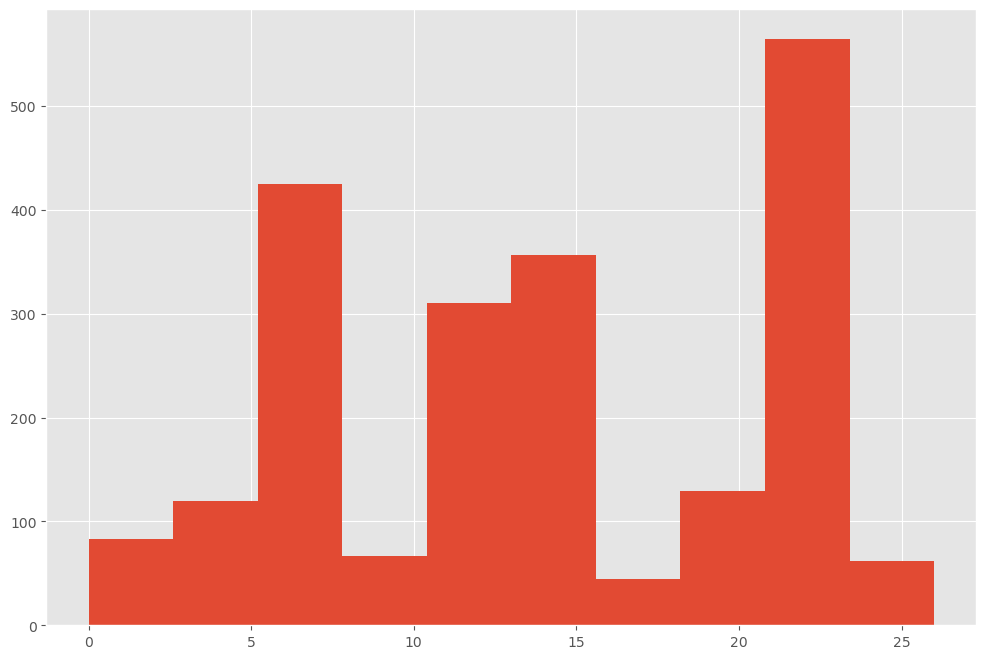

In [16]:
y_train.hist()

Oversampling
https://www.blog.trainindata.com/oversampling-techniques-for-imbalanced-data/


In [18]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

# Paso 1: Aplicar RandomOverSampler a todas las clases
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Paso 2: Aplicar SMOTE solo a clases que tienen suficientes muestras después de RandomOverSampler
# Especifica el número mínimo de muestras necesarias para aplicar SMOTE
min_samples_for_smote = 5
eligible_classes = [clase for clase, cuenta in Counter(y_train_resampled).items() if cuenta >= min_samples_for_smote]

# Crear un diccionario de estrategia para SMOTE solo para las clases con suficientes muestras
smote_strategy = {clase: Counter(y_train_resampled).most_common(1)[0][1] for clase in eligible_classes}

# Aplicar SMOTE
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train_resampled, y_train_resampled)

# Verificar la nueva distribución de clases
print("Distribución de clases después de aplicar SMOTE:")
print(Counter(y_train_smote))

X_train_resampled= X_train_smote
y_train_resampled = y_train_smote


Distribución de clases después de aplicar SMOTE:
Counter({7: 380, 13: 380, 12: 380, 19: 380, 22: 380, 26: 380, 6: 380, 23: 380, 11: 380, 4: 380, 21: 380, 18: 380, 17: 380, 15: 380, 2: 380, 25: 380, 1: 380, 20: 380, 8: 380, 14: 380, 0: 380, 10: 380, 3: 380, 16: 380, 5: 380, 24: 380})


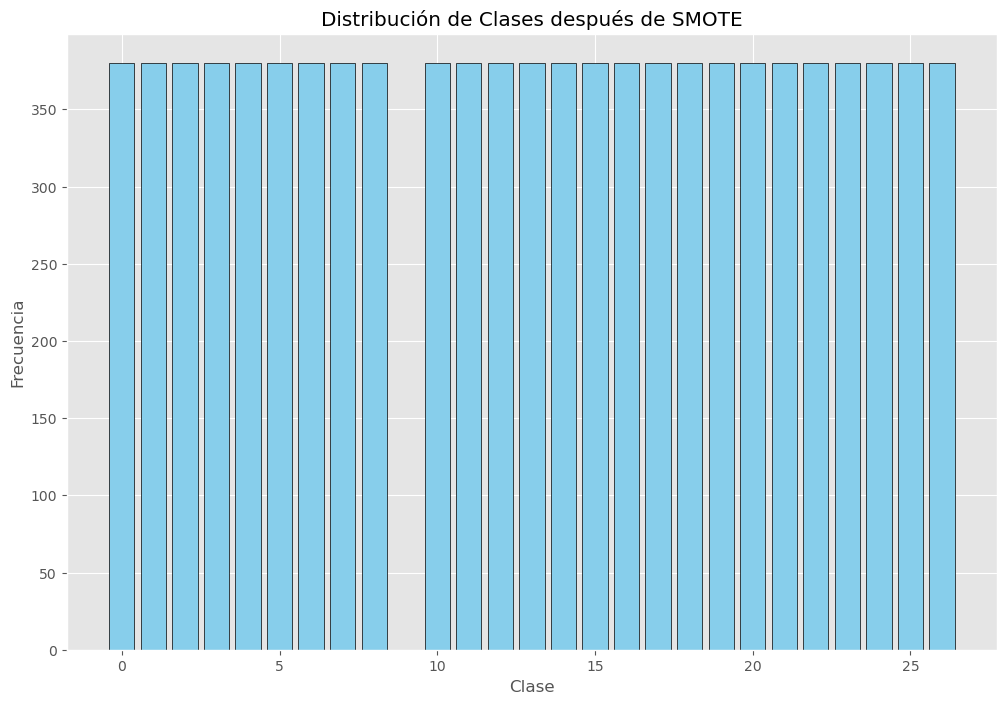

In [154]:
import matplotlib.pyplot as plt
from collections import Counter

# Contar las instancias de cada clase en y_train_smote
counter = Counter(y_train_smote)

# Graficar
plt.bar(counter.keys(), counter.values(), color='skyblue', edgecolor='black')
plt.title('Distribución de Clases después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


In [20]:
X_train_resampled.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train_resampled.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [21]:
from sklearn.feature_selection import VarianceThreshold

# Inicializar el transformador para eliminar las características constantes (varianza 0)
selector = VarianceThreshold(threshold=0)

# Aplicar el transformador a los datos (X_train o tu conjunto de características)
X_reduced = selector.fit_transform(X_train)

# Para saber qué características fueron eliminadas:
removed_features = X_train.columns[~selector.get_support()]

print(f"Las características eliminadas son: {removed_features}")


Las características eliminadas son: Index([], dtype='object')


In [22]:
X_train=X_reduced

In [23]:
import sklearn
print(sklearn.__version__)

1.5.2


In [24]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


Modelo pipeline

In [26]:
from sklearn.tree import DecisionTreeClassifier   # Árbol de decisión
arbol = DecisionTreeClassifier()


from sklearn.ensemble import RandomForestClassifier   # Random forest
random_forest = RandomForestClassifier()


from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting
gradient_boosting = GradientBoostingClassifier()


from sklearn.preprocessing import StandardScaler     # importamos StandardScaler para realizar la estandarización cuando sea necesaria
from sklearn.feature_selection import RFECV, SelectKBest, f_classif  # importanmos RFECV y SeleckBest que los usaré para la selección de variables
from sklearn.linear_model import LogisticRegression

logreg_rfecv = Pipeline(steps=[("scaler",StandardScaler()),
                               ("rfecv",RFECV(estimator=LogisticRegression())),   #Aquí usamos regresión logística usando la selección RFECV
                               ("logreg",LogisticRegression())
                              ]
                       )

logreg_kbest = Pipeline(steps=[("scaler",StandardScaler()),
                               ("kbest",SelectKBest()), # Aquí usamos la regresión logística con SelectKBest para selección de variables
                               ("logreg",LogisticRegression())
                              ]
                       )

from sklearn.neighbors import KNeighborsClassifier
neighbors = Pipeline(steps=[("scaler",StandardScaler()),  # KNeighbors sin realizar selección de variables.
                            ("knn",KNeighborsClassifier())
                          ]
                   )


neighbors_kbest = Pipeline(steps=[("scaler",StandardScaler()),
                                  ("kbest",SelectKBest()),  # KNeighbors con selección de variables mediante el método SelectKBest
                                  ("knn",KNeighborsClassifier())
                                ]
                         )


from sklearn.svm import SVC
svm = Pipeline(steps=[("scaler",StandardScaler()), # Support Vector Machine, kernel es brf por defecto
                      ("svm",SVC())
                     ]
              )

svm_kbest = Pipeline(steps=[("scaler",StandardScaler()),
                            ("kbest",SelectKBest()),    # Support Vector Machine, con método de selección kbest
                            ("svm",SVC())])



# Naïve Bayes

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_kbest = Pipeline(steps=[("kbest",SelectKBest()),
                           ("nb",GaussianNB())])


# Perceptrón multicapa sin elegir ningún tipo de selección:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline(steps=[("scaler",StandardScaler()),
                      ("mlp",MLPClassifier())])


from sklearn.ensemble import BaggingClassifier
## Baggin tomando como estimador un árbol de decisión

dt = DecisionTreeClassifier()
bc = BaggingClassifier(estimator=dt, n_estimators=50, oob_score=True, random_state=1)


                            

## Adaboost de regresiones logísticas
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Use LogisticRegression as an estimator in BaggingClassifier
lr = LogisticRegression()
ab = BaggingClassifier(estimator=lr, n_estimators=50, random_state=1)

In [27]:
# Hiperparametros para los modelos

#Los modelos dependen de ciertos parámetros de entrada, estos parámetros deben decidirse antes de entrenar el modelo y una mejor o peor elección de los mismos dará mejores o peores resultados.

#Es posible crear una parrilla de parámetros para cada uno de los modelos y ser probados automáticamente a través de técnicas como GridSearchCV o RandomizedSearchCV.

#Hay ciertas técnicas que ayudan a seleccionar estos parámetros sin tener que hacer pruebas manuales probando combinaciones.  

In [28]:
grid_arbol = {"max_depth":list(range(1,11)) # Profundidades de 1 a 10
              }

grid_random_forest = {"n_estimators": [150],

                     "max_depth": [3,5,10,15,20],

                     "max_features": ["sqrt", 3, 4]                          }



grid_gradient_boosting = {"loss": ["deviance"],
                          "learning_rate": [ 0.1], # Una learning_rate alta
                                                             # junto con n_estimators alta puede dar sobreajuste.

                          "n_estimators": [100], # En GBT un número
                                                           # elevado de árboles puede darnos sobreajuste.

                          "max_depth": [5], # En boosting, los árboles utilizados deben tener poca
                                                    # profundidad ya que van rectificandose poco a poco de forma aditiva.

                          "subsample": [0.5], # Lo usamos para evitar el sobreentrenamiento

                          "max_features": ["sqrt", 3, 4],
                          }


# Ahora las Pipelines de regresiones logísticas:

grid_logreg_rfecv = {"rfecv__step": [1],
                     "rfecv__cv": [5],

                     "logreg__penalty": ["l1","l2"], # Regularizaciones L1 y L2 para evitar overfitting.
                     "logreg__C": [0.1, 0.8, 5.0], # Con este parámetro elegimos la fuerza de regulación
                     "logreg__fit_intercept": [True],

                     "logreg__max_iter": [50,100,500],

                     "logreg__solver": ["liblinear"]
                    }

grid_logreg_kbest = {"kbest__score_func": [f_classif],
                     "kbest__k": [1,2,3],   # El número de features con las que quedarse.

                     "logreg__penalty": ["l1","l2"],
                     "logreg__C": [0.1, 0.8, 5.0],
                     "logreg__fit_intercept": [True],
                     "logreg__max_iter": [50,100],
                     "logreg__solver": ["liblinear"]
                    }


# Nearest Neighbors:

grid_neighbors = {"knn__n_neighbors": [3,5,7,9,11],
                  "knn__weights": ["uniform","distance"]  # Pondera o no las clasificaciones en
                                                          # función de la inversa de la distancia a cada
                                                          # vecino
                  }

grid_neigbors_kbest = {"kbest__score_func": [f_classif],
                       "kbest__k": [1,2,3],
                       "knn__n_neighbors": [3,6,10],
                       "knn__weights": ["uniform","distance"]
                      }



grid_svm = {"svm__C": [0.1, 5.0, 50.0],
            "svm__kernel": ["rbf"],
            "svm__gamma": [0.001, 1, 10.0]
           }

grid_svm_kbest = {"kbest__score_func": [f_classif],
                  "kbest__k": [1,2,3],
                  "svm__C": [0.1, 5.0, 50.0],
                  "svm__kernel": ["rbf"],
                  "svm__gamma": [0.001, 1, 10.0]
                 }


# Naïve Bayes:

grid_nb_kbest = {"kbest__score_func": [f_classif],
                 "kbest__k": [1,2,3]
                }

# MLP:

grid_mlp = {"mlp__hidden_layer_sizes": [(4,),
                                        (4,4),
                                        (30,),
                                        (30,30)],

           "mlp__activation": ["logistic"],

           "mlp__solver": ["adam"],

           "mlp__alpha": [0.0, 0.1],

           "mlp__validation_fraction": [0.1],
           "mlp__early_stopping": [True],
           "mlp__max_iter": [3000],

           "mlp__learning_rate_init": [0.001, 0.1]
           }


grid_bc = {"n_estimators": [10, 20],
           "estimator__max_leaf_nodes":[5,15],
           "estimator__max_depth":[4,6]
          }

grid_ab= {"n_estimators":[5,10,30]
        
              }

In [29]:
#Grid search y entrenamiento:

In [30]:
from sklearn.model_selection import GridSearchCV

gs_ab= GridSearchCV(ab,
                    grid_ab,
                    cv=10,
                    scoring='f1_micro',
                    verbose=1,
                    n_jobs=-1)

gs_bc= GridSearchCV(bc,
                    grid_bc,
                    cv=10,
                    scoring='f1_micro',
                    verbose=1,
                    n_jobs=-1)


gs_arbol = GridSearchCV(arbol,
                        grid_arbol,
                        cv=10,
                        scoring="f1_micro",
                        verbose=1,
                        n_jobs=-1)

gs_random_forest = GridSearchCV(random_forest,
                                grid_random_forest,
                                cv=10,
                                scoring='f1_micro',
                                verbose=1,
                                n_jobs=-1)
gs_gradient_boosting = GridSearchCV(gradient_boosting,
                                    grid_gradient_boosting,
                                    cv=10,
                                    scoring='f1_micro',
                                    verbose=1,
                                    n_jobs=-1,
                                    error_score='raise') # Add this parameter

# Change the value of 'loss' in grid_gradient_boosting to 'log_loss'
for i, g in enumerate(grid_gradient_boosting):
    if 'loss' in g:
        grid_gradient_boosting['loss'] = ['log_loss']

gs_logreg_rfecv = GridSearchCV(logreg_rfecv,
                               grid_logreg_rfecv,
                               cv=10,
                               scoring='f1_micro',
                               verbose=1,
                               n_jobs=-1)

gs_logreg_kbest = GridSearchCV(logreg_kbest,
                               grid_logreg_kbest,
                               cv=10,
                               scoring='f1_micro',
                               verbose=1,
                               n_jobs=-1)

gs_neighbors = GridSearchCV(neighbors,
                            grid_neighbors,
                            cv=10,
                            scoring='f1_micro',
                            verbose=1,
                            n_jobs=-1)

gs_neighbors_kbest = GridSearchCV(neighbors_kbest,
                                  grid_neigbors_kbest,
                                  cv=10,
                                  scoring='f1_micro',
                                  verbose=1,
                                  n_jobs=-1)

gs_svm = GridSearchCV(svm,
                      grid_svm,
                      cv=10,
                      scoring='f1_micro',
                      verbose=1,
                      n_jobs=-1)

gs_svm_kbest = GridSearchCV(svm_kbest,
                            grid_svm_kbest,
                            cv=10,
                            scoring='f1_micro',
                            verbose=1,
                            n_jobs=-1)

gs_nb = GridSearchCV(nb,
                     {},  # No hay grid
                     cv=10,
                     scoring='f1_micro',
                     verbose=1,
                     n_jobs=-1)

gs_nb_kbest = GridSearchCV(nb_kbest,
                           grid_nb_kbest,
                           cv=10,
                           scoring='f1_micro',
                           verbose=1,
                           n_jobs=-1)

gs_mlpC = GridSearchCV(mlp,
                      grid_mlp,
                      cv=10,
                      scoring='f1_micro',
                      verbose=1,
                      n_jobs=-1)

Entrenamiento
solo con los 4 mejores

In [32]:

'''todos_los_grid_searchs = {"gs_arbol":gs_arbol,
                          "gs_random_forest":gs_random_forest,
                          "gs_gradient_boosting":gs_gradient_boosting,
                          "gs_logreg_rfecv":gs_logreg_rfecv,
                          "gs_logreg_kbest":gs_logreg_kbest,
                          "gs_neighbors":gs_neighbors,
                          "gs_neighbors_kbest":gs_neighbors_kbest,
                          "gs_svm":gs_svm,
                          "gs_svm_kbest":gs_svm_kbest,
                          "gs_nb":gs_nb,
                          "gs_nb_kbest":gs_nb_kbest,
                          "gs_mlpC":gs_mlpC,
                          "gs_bc": gs_bc,
                          "gs_ab": gs_ab}'''



todos_los_grid_searchs = {"gs_neighbors":gs_neighbors,
                          "gs_svm":gs_svm,
                          "gs_random_forest":gs_random_forest,
                          "gs_gradient_boosting":gs_gradient_boosting}


In [33]:
import time

start = time.time()

In [34]:
for nombre, grid_search in todos_los_grid_searchs.items():
    print("Haciendo Grid Search de %s..." % nombre)
    grid_search.fit(X_train_resampled, y_train_resampled)

Haciendo Grid Search de gs_neighbors...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Haciendo Grid Search de gs_svm...
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Haciendo Grid Search de gs_random_forest...
Fitting 10 folds for each of 15 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Haciendo Grid Search de gs_gradient_boosting...
Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [35]:
print("Los segundos transcurridos son:")

end = time.time()

print(end - start)

Los segundos transcurridos son:
114.18116998672485


In [36]:
mejor_score_de_cada_gridsearch = [(nombre_modelo, grid_search.best_score_) # Generamos una tupla
                                  for nombre_modelo, grid_search           # por cada par clave-valor
                                  in todos_los_grid_searchs.items()]       # del diccionario

mejor_score_de_cada_gridsearch

[('gs_neighbors', 0.9626518218623481),
 ('gs_svm', 0.972570850202429),
 ('gs_random_forest', 0.9915991902834008),
 ('gs_gradient_boosting', 0.9941295546558704)]

In [37]:
mejor_score_de_cada_gridsearch_df = pd.DataFrame(mejor_score_de_cada_gridsearch,
                                                 columns=["GridSearchCV", "Mejor score"])

mejor_score_de_cada_gridsearch_df_ordenado = (mejor_score_de_cada_gridsearch_df
                                              .sort_values(by="Mejor score", ascending=False)
                                             )

mejor_score_de_cada_gridsearch_df_ordenado

,GridSearchCV,Mejor score
3,gs_gradient_boosting,0.994130
2,gs_random_forest,0.991599
1,gs_svm,0.972571
0,gs_neighbors,0.962652


In [38]:
#la mejor puntuación es de gs_gradient_boosting

In [39]:
mejor_gridsearch_clas = todos_los_grid_searchs["gs_gradient_boosting"]

In [40]:
mejor_pipeline = mejor_gridsearch_clas.best_estimator_
mejor_pipeline
mejor_pipeline.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [41]:
mejor_pipeline.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(max_depth=5, max_features=3, subsample=0.5)

In [42]:
from sklearn.metrics import f1_score

f1_en_test = f1_score(y_true = y_test,
                                  y_pred = mejor_pipeline.predict(X_test), average="micro"
                                 )

print("El modelo tiene un f1 en el conjunto de test de %s" % f1_en_test)

#from sklearn.metrics import accuracy_score

#accuracy_en_test = accuracy_score(y_true = y_test,
                                #  y_pred = mejor_pipeline.predict(X_test)
                               #  )
#
#print("El modelo tiene un accuracy en el conjunto de test de %s" % accuracy_en_test)

El modelo tiene un f1 en el conjunto de test de 0.9094269870609981


In [43]:
# classification report
classr = classification_report(y_test, mejor_pipeline.predict(X_test))
print(classr)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       1.00      0.88      0.93         8
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         6
           4       0.95      0.90      0.92        20
           5       1.00      1.00      1.00         1
           6       0.97      0.99      0.98        87
           7       0.71      0.86      0.77        14
           8       0.92      1.00      0.96        22
           9       0.00      0.00      0.00         1
          11       1.00      0.67      0.80         3
          12       0.86      0.94      0.90        79
          13       0.88      0.80      0.84        64
          14       1.00      0.92      0.96        12
          15       1.00      1.00      1.00        23
          16       1.00      0.67      0.80         3
          17       0.50      1.00      0.67         1
          18       0.80    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
from sklearn.metrics import confusion_matrix

matriz_confusion = confusion_matrix(y_true = y_test,
                                    y_pred = mejor_pipeline.predict(X_test)
                                   )
matriz_confusion

array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 18,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 86,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0,  0,  0,  0,  0, 

In [45]:
matriz_confusion_df = pd.DataFrame(matriz_confusion)

# Y nombramos lo que son las columnas y las filas:
matriz_confusion_df.columns.name = "Predicción"
matriz_confusion_df.index.name = "Real"
matriz_confusion_df

Predicción,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Real,,,,,,,,,,,,,,,,,,,,,
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,7,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,18,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,86,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,22,0,...,0,0,0,0,0,0,0,0,0,0


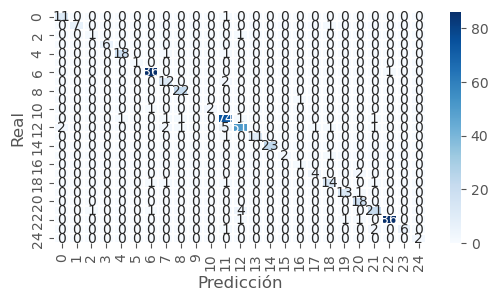

In [46]:
plt.figure(figsize=(6,3))
sns.heatmap(matriz_confusion_df,
            annot=True,
            cmap="Blues",linewidths=.10, fmt= '.0f')
pass

In [47]:
mejor_gridsearch_clas = todos_los_grid_searchs["gs_gradient_boosting"]

In [48]:
mejor_pipeline = mejor_gridsearch_clas.best_estimator_
mejor_pipeline
mejor_pipeline.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [49]:
mejor_pipeline.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(max_depth=5, max_features=3, subsample=0.5)

Tiempo transcurrido para calcular la importancia de características: 1.353 segundos


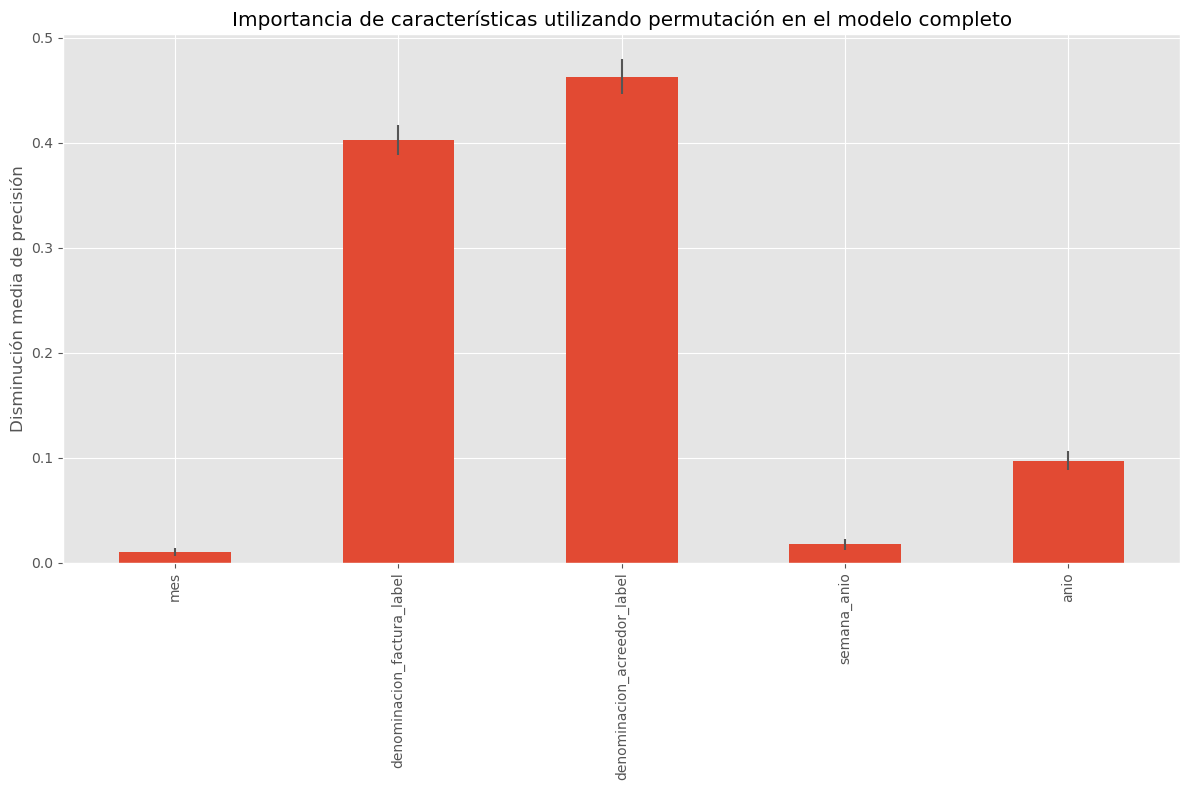

In [149]:
import time
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que 'modelo_entrenado', 'X_test' y 'y_test' están definidos
start_time = time.time()
result = permutation_importance(
    gs_gradient_boosting, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Tiempo transcurrido para calcular la importancia de características: {elapsed_time:.3f} segundos")

# Crear una serie con las importancias
importancias = pd.Series(result.importances_mean, index=X_test.columns)

# Crear gráfico de barras
fig, ax = plt.subplots()
importancias.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Importancia de características utilizando permutación en el modelo completo")
ax.set_ylabel("Disminución media de precisión")
fig.tight_layout()
plt.show()


In [50]:
from sklearn.metrics import f1_score

f1_en_test = f1_score(y_true = y_test,
                                  y_pred = mejor_pipeline.predict(X_test), average="micro"
                                 )

print("El modelo tiene un f1 en el conjunto de test de %s" % f1_en_test)

#from sklearn.metrics import accuracy_score

#accuracy_en_test = accuracy_score(y_true = y_test,
                                #  y_pred = mejor_pipeline.predict(X_test)
                               #  )
#
#print("El modelo tiene un accuracy en el conjunto de test de %s" % accuracy_en_test)

El modelo tiene un f1 en el conjunto de test de 0.9038817005545287


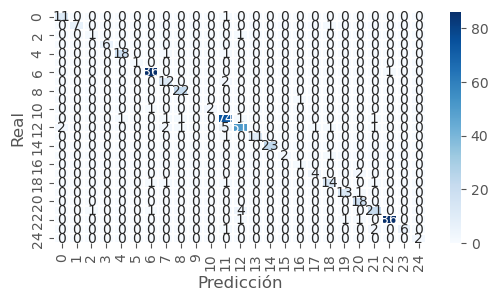

In [51]:
plt.figure(figsize=(6,3))
sns.heatmap(matriz_confusion_df,
            annot=True,
            cmap="Blues",linewidths=.10, fmt= '.0f')
pass

In [52]:
##### 2 gs_random_forest

In [53]:
mejor_gridsearch_clas = todos_los_grid_searchs["gs_random_forest"]

In [54]:
mejor_pipeline = mejor_gridsearch_clas.best_estimator_
mejor_pipeline
mejor_pipeline.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
mejor_pipeline.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, n_estimators=150)

Tiempo transcurrido para calcular la importancia de características: 0.820 segundos


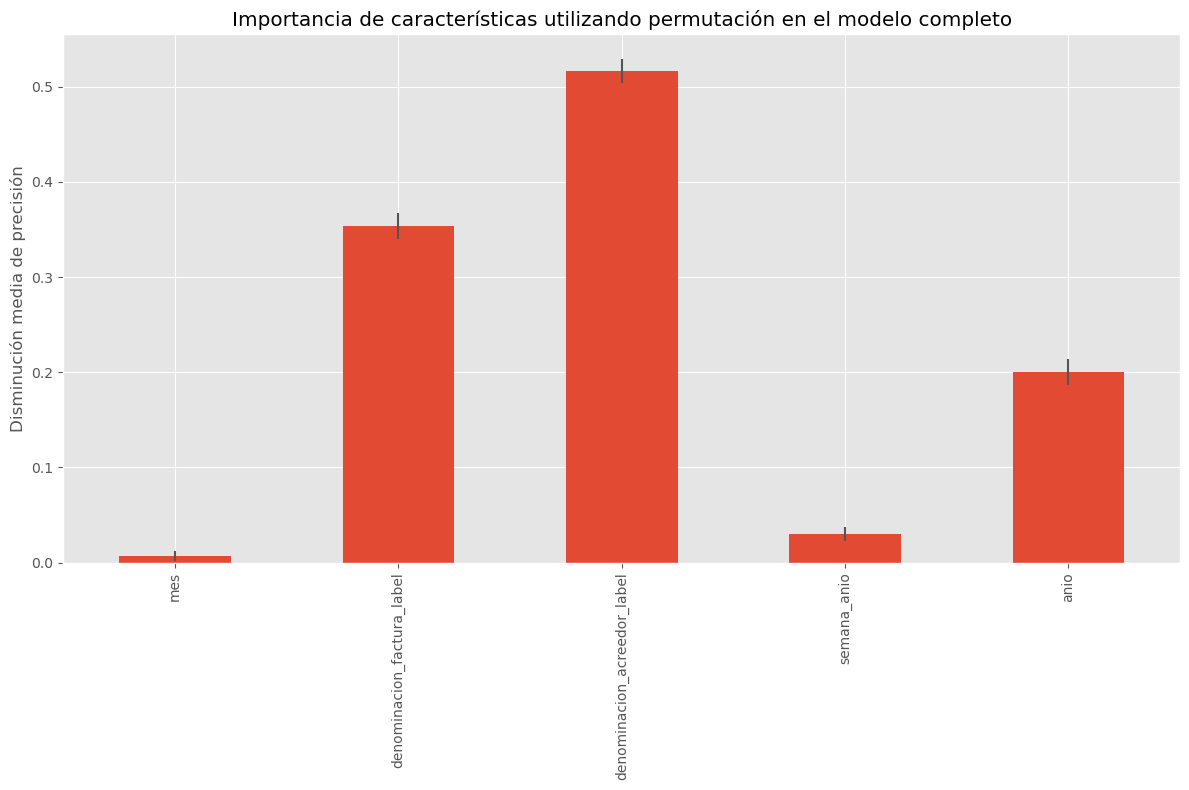

In [151]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que 'modelo_entrenado', 'X_test' y 'y_test' están definidos
start_time = time.time()
result = permutation_importance(
    gs_random_forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Tiempo transcurrido para calcular la importancia de características: {elapsed_time:.3f} segundos")

# Crear una serie con las importancias
importancias = pd.Series(result.importances_mean, index=X_test.columns)

# Crear gráfico de barras
fig, ax = plt.subplots()
importancias.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Importancia de características utilizando permutación en el modelo completo")
ax.set_ylabel("Disminución media de precisión")
fig.tight_layout()
plt.show()


In [56]:
from sklearn.metrics import f1_score

f1_en_test = f1_score(y_true = y_test,
                                  y_pred = mejor_pipeline.predict(X_test), average="micro"
                                 )

print("El modelo tiene un f1 en el conjunto de test de %s" % f1_en_test)

#from sklearn.metrics import accuracy_score

#accuracy_en_test = accuracy_score(y_true = y_test,
                                #  y_pred = mejor_pipeline.predict(X_test)
                               #  )
#
#print("El modelo tiene un accuracy en el conjunto de test de %s" % accuracy_en_test)

El modelo tiene un f1 en el conjunto de test de 0.8521256931608133


In [57]:
# classification report
classr = classification_report(y_test, mejor_pipeline.predict(X_test))
print(classr)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       1.00      0.62      0.77         8
           2       0.25      0.50      0.33         2
           3       0.86      1.00      0.92         6
           4       0.86      0.90      0.88        20
           5       1.00      1.00      1.00         1
           6       0.88      0.97      0.92        87
           7       0.67      0.86      0.75        14
           8       0.79      0.86      0.83        22
           9       0.00      0.00      0.00         1
          11       1.00      0.67      0.80         3
          12       0.87      0.87      0.87        79
          13       0.74      0.67      0.70        64
          14       1.00      0.92      0.96        12
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00         3
          17       0.00      0.00      0.00         1
          18       1.00    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hiperparametros para los modelos
Los modelos dependen de ciertos parámetros de entrada, estos parámetros deben decidirse antes de entrenar el modelo y una mejor o peor elección de los mismos dará mejores o peores resultados.

Es posible crear una parrilla de parámetros para cada uno de los modelos y ser probados automáticamente a través de técnicas como GridSearchCV o RandomizedSearchCV.

Hay ciertas técnicas que ayudan a seleccionar estos parámetros sin tener que hacer pruebas manuales probando combinaciones.

In [59]:
from sklearn.metrics import confusion_matrix

matriz_confusion = confusion_matrix(y_true = y_test,
                                    y_pred = mejor_pipeline.predict(X_test)
                                   )

In [60]:
matriz_confusion_df = pd.DataFrame(matriz_confusion)

# Y nombramos lo que son las columnas y las filas:
matriz_confusion_df.columns.name = "Predicción"
matriz_confusion_df.index.name = "Real"
matriz_confusion_df

Predicción,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Real,,,,,,,,,,,,,,,,,,,,,
0,10,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,0,0,0,0,0,2,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,84,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,12,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,0,0,0,0,0,0


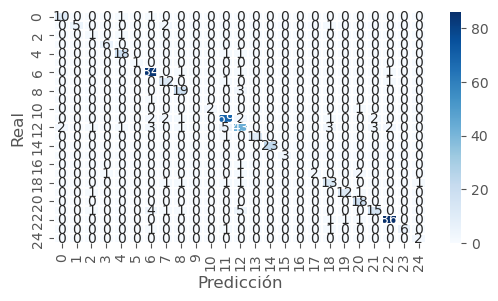

In [61]:
plt.figure(figsize=(6,3))
sns.heatmap(matriz_confusion_df,
            annot=True,
            cmap="Blues",linewidths=.10, fmt= '.0f')
pass

In [62]:
###### 3 gs_neighbors

In [63]:
mejor_gridsearch_clas = todos_los_grid_searchs["gs_neighbors"]

In [64]:
mejor_pipeline = mejor_gridsearch_clas.best_estimator_
mejor_pipeline
mejor_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=3, weights='distance'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 3,
 'knn__p': 2,
 'knn__weights': 'distance'}

In [65]:
mejor_pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [66]:
from sklearn.metrics import f1_score

f1_en_test = f1_score(y_true = y_test,
                                  y_pred = mejor_pipeline.predict(X_test), average="micro"
                                 )

print("El modelo tiene un f1 en el conjunto de test de %s" % f1_en_test)

#from sklearn.metrics import accuracy_score

#accuracy_en_test = accuracy_score(y_true = y_test,
                                #  y_pred = mejor_pipeline.predict(X_test)
                               #  )
#
#print("El modelo tiene un accuracy en el conjunto de test de %s" % accuracy_en_test)

El modelo tiene un f1 en el conjunto de test de 0.609981515711645


In [67]:
# classification report
classr = classification_report(y_test, mejor_pipeline.predict(X_test))
print(classr)

              precision    recall  f1-score   support

           0       0.43      0.75      0.55        12
           1       0.71      0.62      0.67         8
           2       0.17      0.50      0.25         2
           3       0.62      0.83      0.71         6
           4       0.50      0.60      0.55        20
           5       1.00      1.00      1.00         1
           6       0.80      0.61      0.69        87
           7       0.35      0.57      0.43        14
           8       0.71      0.68      0.70        22
           9       0.00      0.00      0.00         1
          11       0.33      0.67      0.44         3
          12       0.71      0.56      0.62        79
          13       0.43      0.31      0.36        64
          14       0.64      0.75      0.69        12
          15       0.61      0.87      0.71        23
          16       0.50      0.33      0.40         3
          17       0.00      0.00      0.00         1
          18       0.50    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
from sklearn.metrics import confusion_matrix

matriz_confusion = confusion_matrix(y_true = y_test,
                                    y_pred = mejor_pipeline.predict(X_test)
                                   )

In [69]:
matriz_confusion_df = pd.DataFrame(matriz_confusion)

# Y nombramos lo que son las columnas y las filas:
matriz_confusion_df.columns.name = "Predicción"
matriz_confusion_df.index.name = "Real"
matriz_confusion_df

Predicción,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Real,,,,,,,,,,,,,,,,,,,,,
0,9,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,5,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,5,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2,0,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,1,2,1,1,0,53,2,0,0,...,0,1,1,3,0,6,4,0,0,0
7,0,0,0,0,0,0,0,8,0,0,...,0,1,0,0,0,0,0,1,1,0
8,0,0,0,0,0,0,1,1,15,0,...,0,0,0,2,0,0,0,0,0,0


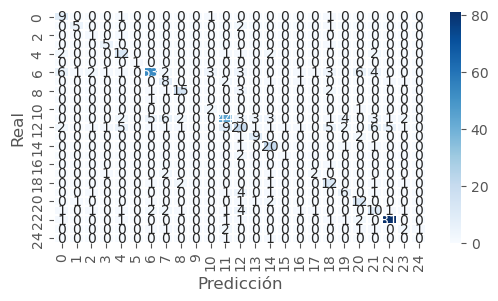

In [70]:
plt.figure(figsize=(6,3))
sns.heatmap(matriz_confusion_df,
            annot=True,
            cmap="Blues",linewidths=.10, fmt= '.0f')
pass